# Dataplex Universal Catalog Introduction
<hr>
<hr>
<font color='red'>Make sure to run the prerequisites script prerequisites.sh </font>




This notebook will provide an introduction in the Dataplex Universal Catalog (DUC).  In order to understand the DUC, it is important to understand the associated concept model which is described below:
<hr>

## Dataplex Universal Catalog Metadata Model

The Dataplex Catalog Concept Model is built around three main components for organizing and defining metadata:<BR>

<B>Entry:</B> This is the core resource being cataloged (e.g., a BigQuery table, a file). It is contained within an Entry Group.
<BR>
<B>Aspects:</B> These represent the actual metadata captured within an Entry (analogous to Tags in Data Catalog). Aspects are defined by Aspect Types, which specify the template of fields.
<BR>
<B>Entry Type:</B> This is a new concept that defines a set of Required aspects for all its entries, ensuring minimal metadata standards and consistency across the catalog. Optional aspects can be added to an entry as needed.
<hr>
The diagram below depicts the concept model: <BR>

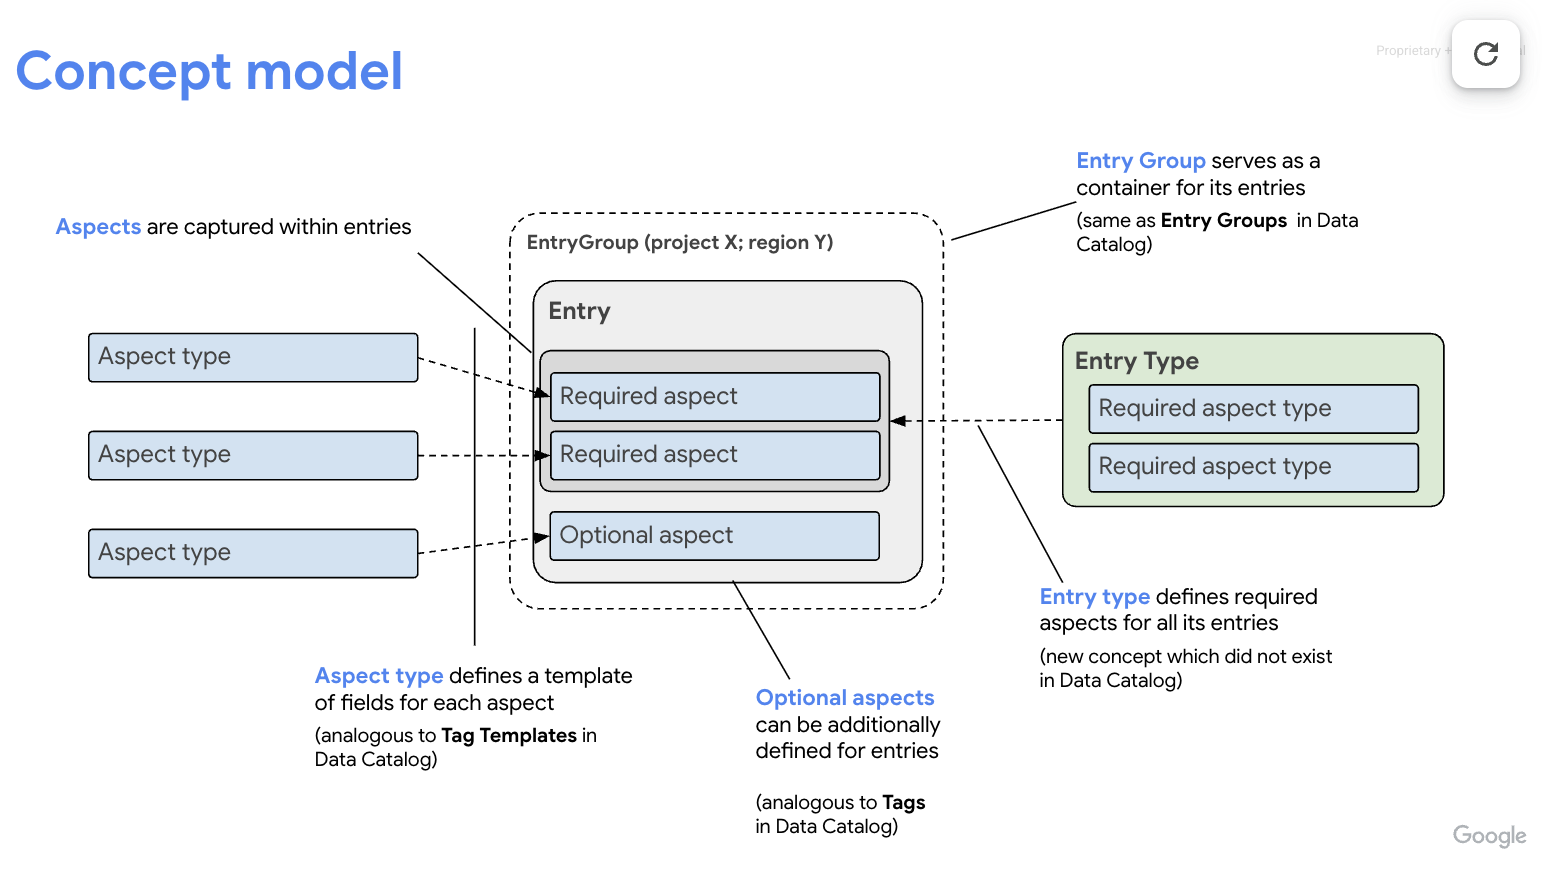





# Data Organization and Security

The diagrams below shows the data organization and data security layout for this lab: <BR>
<hr>

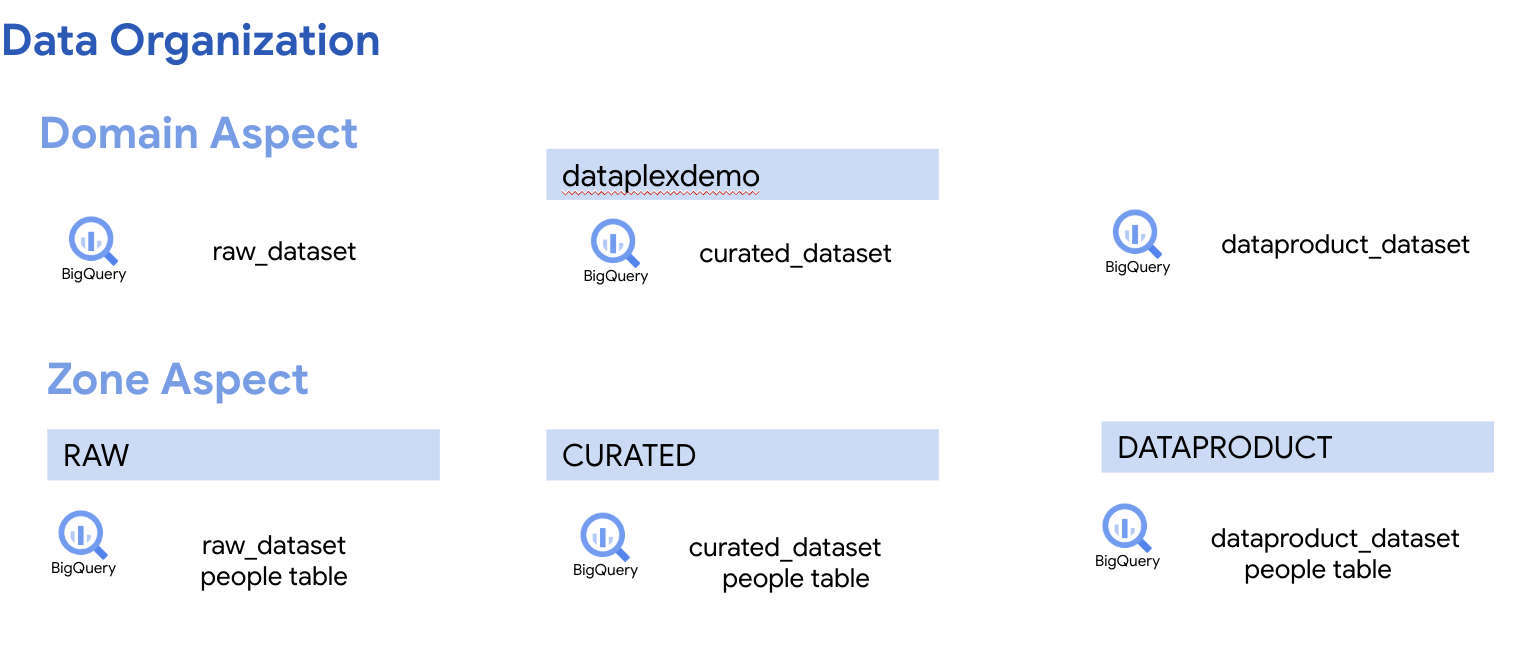

<hr>

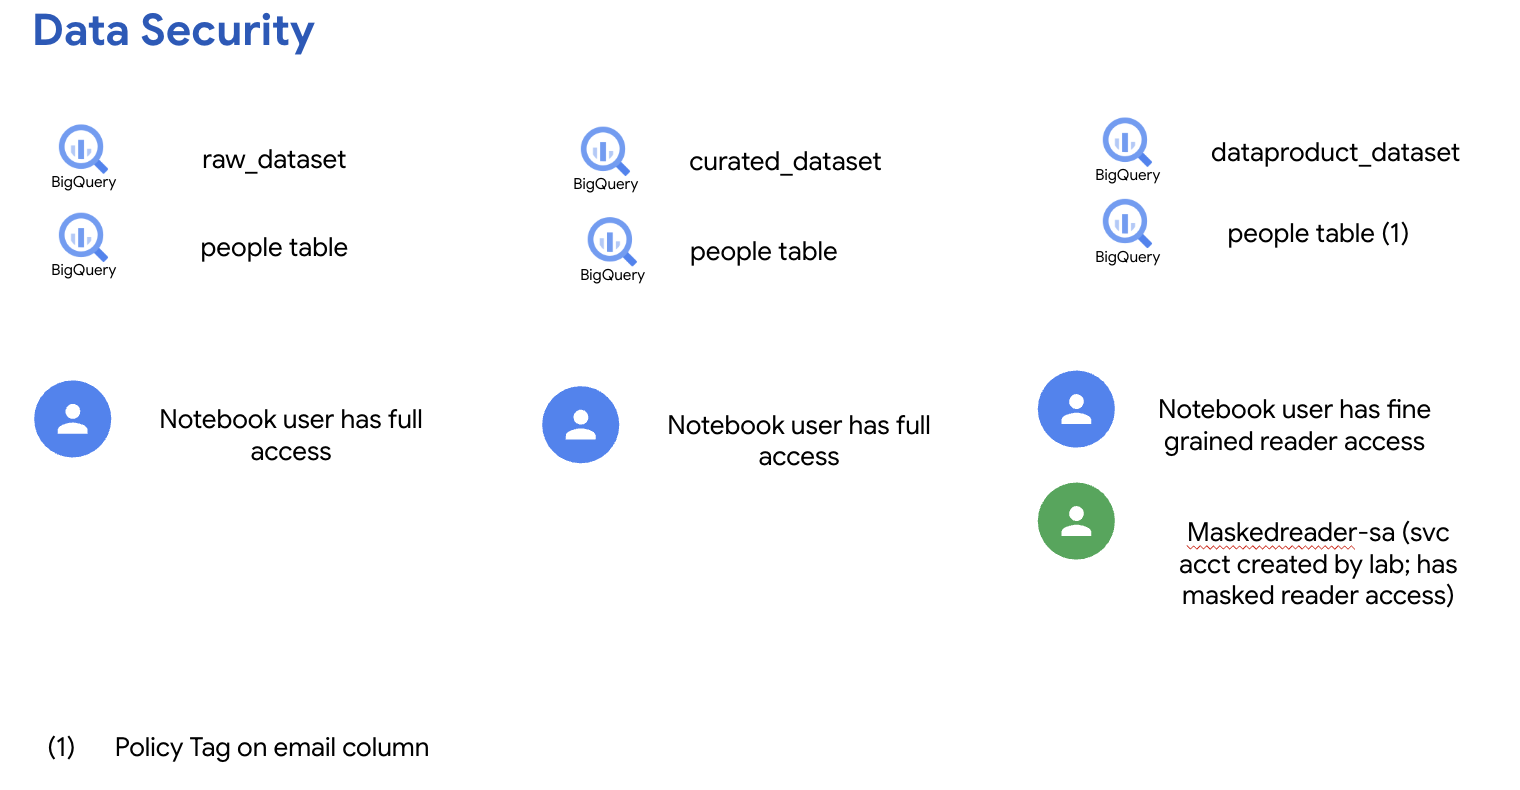

<hr>

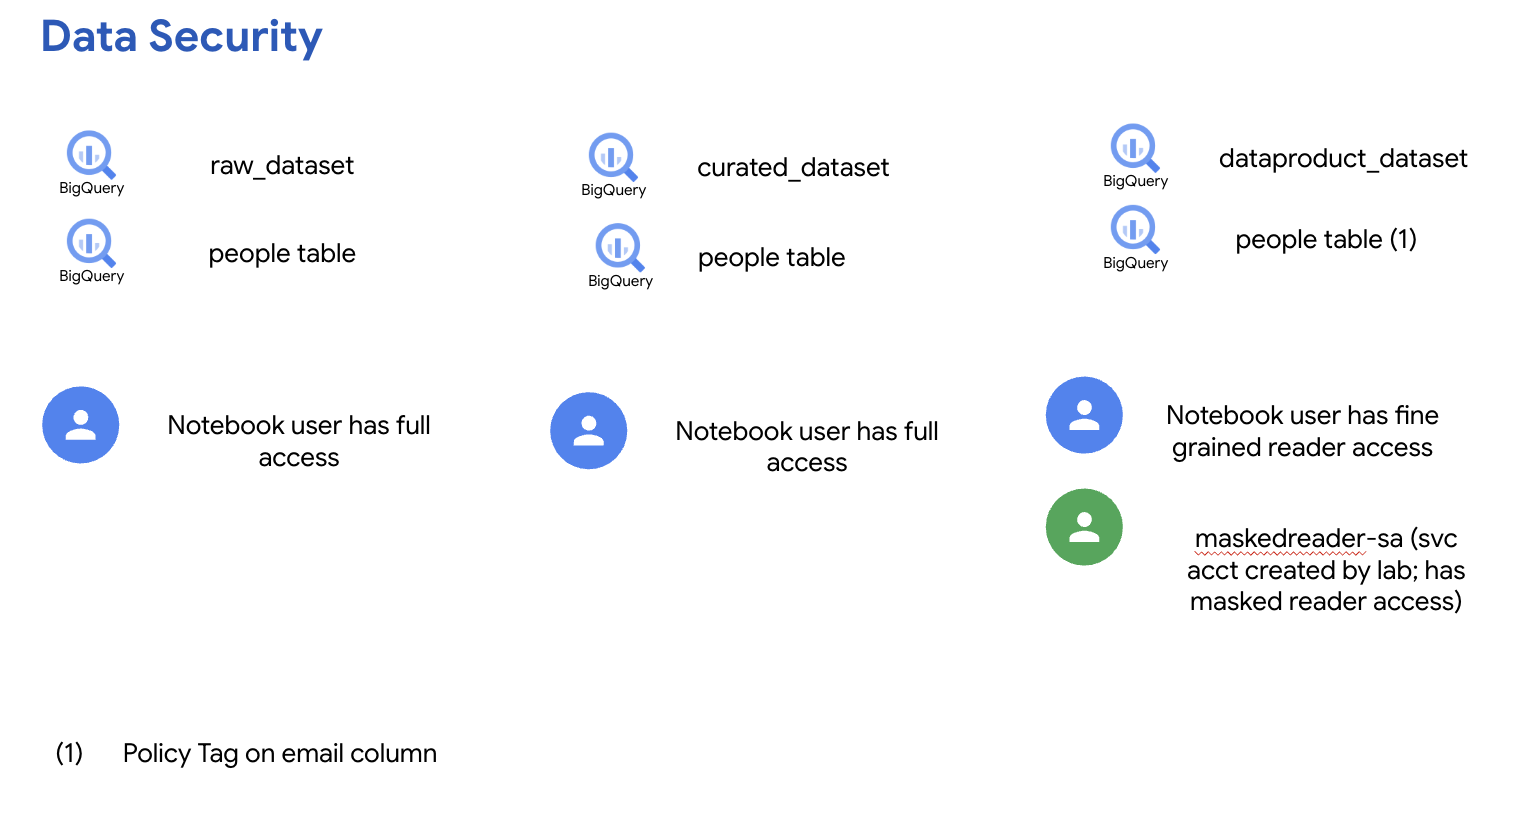

<hr>

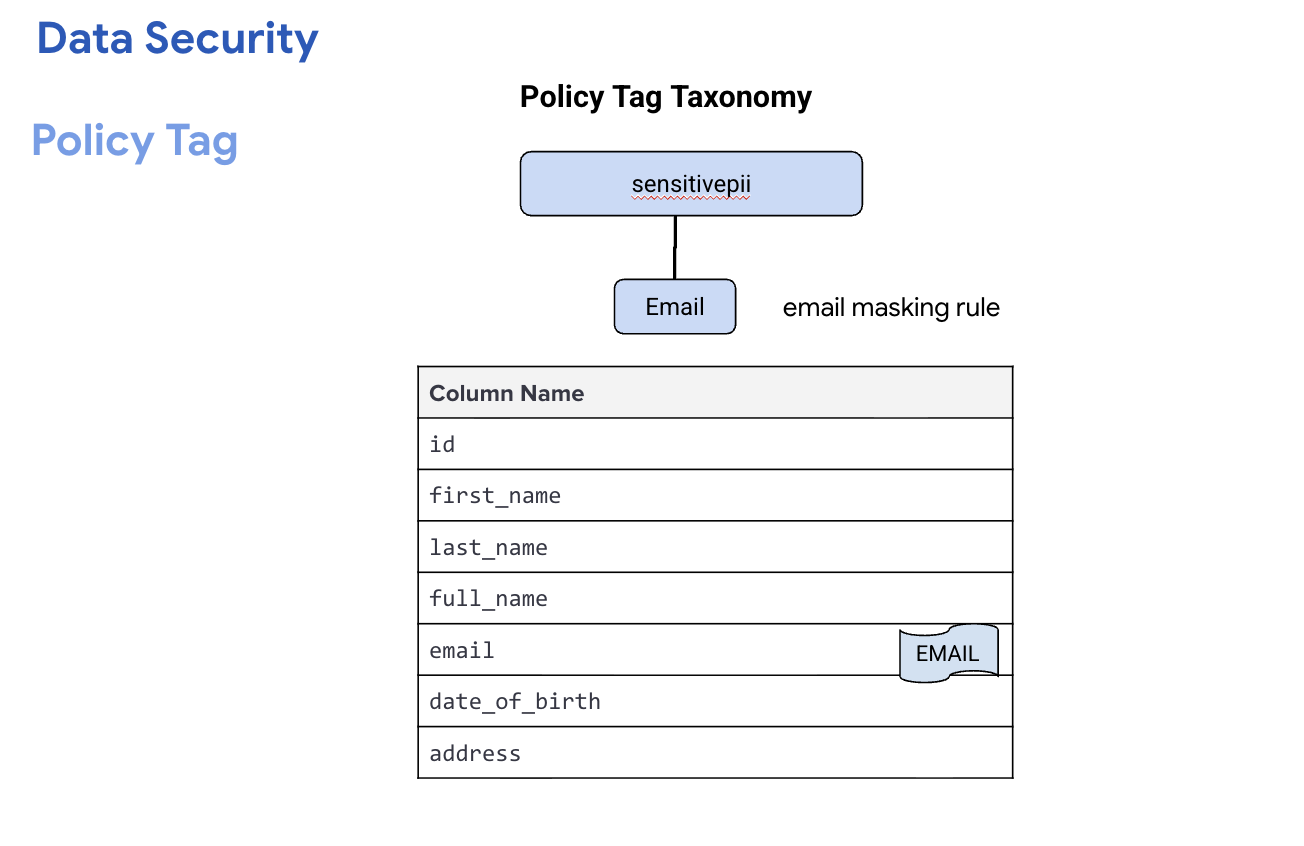


**Overview**: The purpose of this workshop is to show how to use the Dataplex Universal Catalog.

This notebook will generate synthetic data using the 'faker' python package in a CSV file, load this data to GCS and then to BigQuery.  Also, custom aspects will be applied to the entry in the catalog.   Finally, the notebook will demonstrate using various search techniques with the Catalog.

**Process Flow:**

1.  Create CSV File using Faker.
2.  Load CSV File to GCS.
3.  Load GCS CSV File to BigQuery Table
4.  Create and apply aspects to BigQuery Table
5.  Search using the Dataplex Universal Catalog UI

Notes:
* <B>MAKE SURE TO RUN THE PREREQUISITES SCRIPT</B>.

Cost:
* Approximate cost: Less than 1 dollar

Author:
* Jay O'Leary

# License

```
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
```

# Prerequisites



- See [Prerequisites](./README.md#prerequisites)

# Pip Installs

In [ ]:
!pip install Faker

# Initialize

In [ ]:
from google.cloud import storage
import subprocess
import json
import csv
from faker import Faker
import uuid

#Declare some variables
GCP_PROJECT_ID  = ! gcloud config get project
GCP_PROJECT_ID  = GCP_PROJECT_ID[0]
PROJECT_NUMBER  = !gcloud projects describe {GCP_PROJECT_ID} | grep projectNumber | cut -d':' -f2 |  tr -d "'" | xargs
PROJECT_NUMBER  = PROJECT_NUMBER[0]
GCP_LOCATION    = "us-central1"
BIGQUERY_LOCATION        = "us"
RAW_DATASET_NAME         = "raw_dataset"
CURATED_DATASET_NAME     = "curated_dataset"
DATAPRODUCT_DATASET_NAME = "dataproduct_dataset"

TABLE_NAME      = "people"
BUCKET_NAME     = f"dataplexcatalog-demo-{PROJECT_NUMBER}"
# Dataplex Data Lineage API endpoint
DATAPLEX_API_URL=f"https://datalineage.googleapis.com/v1/projects/{GCP_PROJECT_ID}/locations/{GCP_LOCATION}:processOpenLineageRunEvent"
# An OpenLineage namespace for your jobs
OPENLINEAGE_NAMESPACE="bash-scripts-dataplex"
# A unique run ID for this job execution
RUN_ID=uuid.uuid4()
# The name of the fake data file
DATA_FILE=f"faux_data_{RUN_ID}.csv"
# The Name of the custom entry group
ENTRY_GROUP_NAME="lineage-test-entry-group"
# The Name of the custom entry
ENTRY_NAME="lineage-test-entry"
# The Name of the custom entry type
ENTRY_NAME_TYPE="lineage-test-entry-type"
DATASET_SQL = f"create schema {RAW_DATASET_NAME};create schema {CURATED_DATASET_NAME};create schema {DATAPRODUCT_DATASET_NAME};"
VPC_NAME="default"
ASPECT_ZONE_ID="zone"
ASPECT_DOMAIN_ID="domain"
DOMAIN_NAME="dataplexdemo"
TAXONOMY_ID = "sensitivepii"
POLICY_ID = "policyemail"
UMSA="maskedreader-sa"
UMSA_FQN=f"{UMSA}@{GCP_PROJECT_ID}.iam.gserviceaccount.com"


storage_client = storage.Client(project=GCP_PROJECT_ID)


# Helper Methods

** Many of these helper methods are from the [Golden Analytics Demo](https://github.com/GoogleCloudPlatform/data-analytics-golden-demo)

In [ ]:
def restAPIHelper(url: str, http_verb: str, request_body: str) -> str:
  """Calls the Google Cloud REST API passing in the current users credentials"""

  import google.auth.transport.requests
  import requests
  import google.auth
  import json

  # Get an access token based upon the current user
  creds, project = google.auth.default()
  auth_req = google.auth.transport.requests.Request()
  creds.refresh(auth_req)
  access_token=creds.token

  headers = {
    "Content-Type" : "application/json",
    "Authorization" : "Bearer " + access_token
  }

  if http_verb == "GET":
    response = requests.get(url, headers=headers)
  elif http_verb == "POST":
    response = requests.post(url, json=request_body, headers=headers)
  elif http_verb == "PUT":
    response = requests.put(url, json=request_body, headers=headers)
  elif http_verb == "PATCH":
    response = requests.patch(url, json=request_body, headers=headers)
  elif http_verb == "DELETE":
    response = requests.delete(url, headers=headers)
  else:
    raise RuntimeError(f"Unknown HTTP verb: {http_verb}")

  if response.status_code == 200:
    return json.loads(response.content)
    #image_data = json.loads(response.content)["predictions"][0]["bytesBase64Encoded"]
  else:
    error = f"Error restAPIHelper -> ' Status: '{response.status_code}' Text: '{response.text}'"
    raise RuntimeError(error)

In [ ]:
#create bucket if it does not exist
def create_storage_bucket():
  buckets = storage_client.list_buckets()
  bucket_names = [bucket.name for bucket in buckets]

  bucket = storage_client.bucket(BUCKET_NAME)

  if not bucket.exists():
      try:
          bucket = storage_client.create_bucket(BUCKET_NAME)
          print(f"Bucket {bucket.name} created.")
      except Exception as e:
          print(f"Error creating bucket: {e}")
  else:
      print(f"Bucket {BUCKET_NAME} already exists.")

create_storage_bucket()

In [ ]:
def create_aspect_types():

  domain_aspect_type = {
        "name" : "domain",
        "description": "Metadata for identifying the associated Dataplex Zone.",
        "metadataTemplate": {
            "name": "DomainMetadataTemplate",
            "type": "record",
            "recordFields": [
                {
                    "index": 1,
                    "name": "domainname",
                    "type": "string",
                    "annotations": {
                        "displayName": "Domain Name"
                    }
                }
            ]
        }
    }


  url = f"https://dataplex.googleapis.com/v1/projects/{GCP_PROJECT_ID}/locations/{GCP_LOCATION}/aspectTypes?aspectTypeId={ASPECT_DOMAIN_ID}"
  response = restAPIHelper(url, "POST", domain_aspect_type)
  pretty_json = json.dumps(response, indent=4, sort_keys=True)
  print(pretty_json)


  zone_aspect_type = {
        "name" : "zone",
        "displayName": "Zone Type",
        "description": "Indicates the Dataplex Zone where the asset resides.",
        "metadataTemplate": {
            "name": "zone_type_template",
            "type": "record",
            "recordFields": [
            {
                "index": 1,
                "name": "zonename",
                "type": "enum",
                "annotations": {
                "displayName": "Zone Name"
                },
                "enumValues": [
                  {
                    "name": "RAW",
                    "index": 1
                  },
                  {
                    "name": "CURATED",
                    "index": 2
                  },
                  {
                    "name": "DATAPRODUCT",
                    "index": 3
                  }
                ]
             }
          ]
        }
      }

  url = f"https://dataplex.googleapis.com/v1/projects/{GCP_PROJECT_ID}/locations/{GCP_LOCATION}/aspectTypes?aspectTypeId={ASPECT_ZONE_ID}"
  response = restAPIHelper(url, "POST", zone_aspect_type)
  pretty_json = json.dumps(response, indent=4, sort_keys=True)
  print(pretty_json)





In [ ]:
def apply_aspect(resource, aspect_type_name, aspect_field_name, aspect_value):

    aspect_json = {
        "aspects": {
            f"{GCP_PROJECT_ID}.{GCP_LOCATION}.{aspect_type_name}": {
            "data": {
                f"{aspect_field_name}": f"{aspect_value}"
                }
            }
        }
    }

    #projects/jayoleary-477-20250729194504/datasets/rideshare_llm_curated/tables/customer
    #PATCH https://dataplex.googleapis.com/v1/{GCP_PROJECT_ID}/locations/{LOCATION}/entryGroups/@bigquery/entries/*?updateMask=aspects
    #"https://dataplex.googleapis.com/v1/projects/PROJECT_ID/locations/LOCATION_ID/entryGroups/ENTRY_GROUP_ID/entries/ENTRY_ID?updateMask=aspects,entrySource.description" \
    #print(aspect_json)


    url = f"https://dataplex.googleapis.com/v1/projects/{GCP_PROJECT_ID}/locations/{GCP_LOCATION}/entryGroups/@bigquery/entries/{resource}?update_mask=aspects"
    response = restAPIHelper(url, "PATCH", aspect_json)
    pretty_json = json.dumps(response, indent=4, sort_keys=True)
    print(pretty_json)

In [ ]:
def createTaxonomy(project_id, bigquery_location, taxonomy_name, description):
  """Creates a Taxonomy."""

  # First find the connection
  # https://cloud.google.com/data-catalog/docs/reference/rest/v1/projects.locations.taxonomies/list
  url = f"https://datacatalog.googleapis.com/v1/projects/{project_id}/locations/{bigquery_location}/taxonomies"


  # Gather existing connections
  json_result = restAPIHelper(url, "GET", None)
  print(f"createTaxonomy (GET) json_result: {json_result}")

  # Test to see if connection exists, if so return
  if "taxonomies" in json_result:
    for item in json_result["taxonomies"]:
      print(f"displayName: {item['displayName']}")
      # "projects/test/locations/us/taxonomies/2620666826070342226"
      # NOTE: We cannot test the complete name since it contains the an unknown number
      if item["displayName"] == taxonomy_name:
        print("Taxonomy already exists")
        name = item["name"]
        return name

  # Create the taxonomy
  # https://cloud.google.com/data-catalog/docs/reference/rest/v1/projects.locations.taxonomies/create
  print("Creating Taxonomy")

  url = f"https://datacatalog.googleapis.com/v1/projects/{project_id}/locations/{bigquery_location}/taxonomies"

  request_body = {
      "displayName": taxonomy_name,
      "description": description,
  }

  json_result = restAPIHelper(url, "POST", request_body)

  name = json_result["name"]
  print("Taxonomy created: ", name)
  return name


In [ ]:
def createPolicyTag(project_id, taxonomy_name, policy_parent, policy_name):
  """Creates Taxonomy Policy Tag or Sub-Policy Tag"""

  # First find the connection
  # https://cloud.google.com/data-catalog/docs/reference/rest/v1/projects.locations.taxonomies/list


  url = f"https://datacatalog.googleapis.com/v1/{taxonomy_name}/policyTags"

  # Gather existing connections
  json_result = restAPIHelper(url, "GET", None)
  print(f"createTaxonomyPolicyTags (GET) json_result: {json_result}")

  # Test to see if connection exists, if so returns
  if "policyTags" in json_result:
    for item in json_result["policyTags"]:
      # print(f"displayName: {item['displayName']}")
      # "projects/test/locations/us/taxonomies/2620666826070342226"
      # NOTE: We cannot test the complete name since it contains the an unknown number
      if item["displayName"] == policy_name:
        print(f"{policy_name} already exists")
        return item["name"]


  # Create the taxonomy (High)
  # https://cloud.google.com/data-catalog/docs/reference/rest/v1/projects.locations.taxonomies.policyTags/create
  print(f"Creating Policy {policy_name}")

  url = f"https://datacatalog.googleapis.com/v1/{taxonomy_name}/policyTags"

  if policy_parent is  None:
    request_body = {
        "displayName": policy_name,
        "description": "BigQuery Data Governance Demo - " + policy_name,
    }
  else:
    request_body = {
        "parentPolicyTag" : policy_parent,
        "displayName": policy_name,
        "description": "BigQuery Data Governance Demo - " + policy_name,
    }

  json_result = restAPIHelper(url, "POST", request_body)

  policy_full_name = json_result["name"]
  print("Policy created: ", policy_full_name)

  return policy_full_name

In [ ]:
def securePolicyTag(project_id, bigquery_location, user, policy_name):
  """Secure a Policy."""

  # First find the IAM Permission
  # https://cloud.google.com/data-catalog/docs/reference/rest/v1/projects.locations.taxonomies.policyTags/getIamPolicy

  url = f"https://datacatalog.googleapis.com/v1/{policy_name}:getIamPolicy"

  # Gather existing data policies
  request_body = { }
  json_result = restAPIHelper(url, "POST", request_body)
  print(f"getIamPolicy (POST) json_result: {json_result}")

  # Test for existance
  if "bindings" in json_result:
    for item in json_result["bindings"]:
      print(f"role: {item['role']}")
      for member in item["members"]:
        print(f"member: {member}")
        if member == "user:" + user:
          print("securePolicyTag: Permissions exist")
          return

  # Set IAM
  # https://cloud.google.com/data-catalog/docs/reference/rest/v1/projects.locations.taxonomies.policyTags/setIamPolicy
  url = f"https://datacatalog.googleapis.com/v1/{policy_name}:setIamPolicy"

  request_body = {
        "policy": {
            "bindings":[
                {
                    "members": [ "user:" + user ],
                    "role":"roles/datacatalog.categoryFineGrainedReader"
                    }
                ]
            }
        }

  json_result = restAPIHelper(url, "POST", request_body)
  print("IAM Security Set: ", policy_name)

In [ ]:
def securePolicyTagForUMSA(project_id, bigquery_location, svc_account, policy_name):
  """Secure a Policy."""

  # First find the IAM Permission
  # https://cloud.google.com/data-catalog/docs/reference/rest/v1/projects.locations.taxonomies.policyTags/getIamPolicy

  url = f"https://datacatalog.googleapis.com/v1/{policy_name}:getIamPolicy"

  # Gather existing data policies
  request_body = { }
  json_result = restAPIHelper(url, "POST", request_body)
  print(f"getIamPolicy (POST) json_result: {json_result}")

  # Test for existance
  if "bindings" in json_result:
    for item in json_result["bindings"]:
      print(f"role: {item['role']}")
      for member in item["members"]:
        print(f"member: {member}")
        if member == "serviceAccount:" + svc_account:
          print("securePolicyTag: Permissions exist")
          return

  # Set IAM
  # https://cloud.google.com/data-catalog/docs/reference/rest/v1/projects.locations.taxonomies.policyTags/setIamPolicy
  url = f"https://datacatalog.googleapis.com/v1/{policy_name}:setIamPolicy"

  request_body = {
        "policy": {
            "bindings":[
                {
                    "members": [ "serviceAccount:" + svc_account],
                    "role":"roles/datacatalog.categoryFineGrainedReader"
                    }
                ]
            }
        }

  json_result = restAPIHelper(url, "POST", request_body)
  print("IAM Security Set: ", policy_name)

In [ ]:
def updateTableSchema(project_id, dataset_name, table_name, new_schema):
  import io
  import google.cloud.bigquery as bigquery

  client = bigquery.Client()

  dataset_ref = client.dataset(dataset_name, project=project_id)
  table_ref = dataset_ref.table(table_name)
  table = client.get_table(table_ref)

  table.schema = new_schema
  table = client.update_table(table, ["schema"])

  print(f"Table {table_name} schema updated!")

In [ ]:
def createDataPolicy(project_id, bigquery_location, policyTag, policy_name, dataPolicyType, predefinedExpression):
  """Creates a Data Policy."""

  # First find the connection
  # https://cloud.google.com/bigquery/docs/reference/bigquerydatapolicy/rest/v1/projects.locations.dataPolicies/list?

  url = f"https://bigquerydatapolicy.googleapis.com/v1/projects/{project_id}/locations/{bigquery_location}/dataPolicies"

  # Gather existing data policies
  json_result = restAPIHelper(url, "GET", None)
  print(f"createDataPolicies (GET) json_result: {json_result}")

  # Test for policy_name
  if "dataPolicies" in json_result:
    for item in json_result["dataPolicies"]:
      # print(f"name: {item['name']}")
      if item["name"] == f"projects/{project_id}/locations/{bigquery_location}/dataPolicies/{policy_name}":
        print(f"createDataPolicy policy exists: {policy_name}")
        return item["name"]

  # Create Data Policy
  # https://cloud.google.com/bigquery/docs/reference/bigquerydatapolicy/rest/v1/projects.locations.dataPolicies/create
  url = f"https://bigquerydatapolicy.googleapis.com/v1/projects/{project_id}/locations/{bigquery_location}/dataPolicies"

  # Create
  print(f"Creating Data Policy {policy_name}")

  request_body = {
      "dataPolicyId": policy_name,
      "dataPolicyType": dataPolicyType,
      "policyTag" : policyTag,
      "dataMaskingPolicy": {
          "predefinedExpression": predefinedExpression
          }
  }

  json_result = restAPIHelper(url, "POST", request_body)

  policy_name = json_result["name"]
  print("Data Policy created: ", policy_name)

  return policy_name

In [ ]:
def secureDataPolicy(project_id, bigquery_location, user, data_policy_name):
  """Secure a Data Policy."""

  # First find the IAM Permission
  # https://cloud.google.com/bigquery/docs/reference/bigquerydatapolicy/rest/v1/projects.locations.dataPolicies/getIamPolicy

  url = f"https://bigquerydatapolicy.googleapis.com/v1/{data_policy_name}:getIamPolicy"

  # Gather existing data policies
  request_body = { }
  json_result = restAPIHelper(url, "POST", request_body)
  print(f"getIamPolicy (POST) json_result: {json_result}")

  # Test for existance
  members = []
  if "bindings" in json_result:
    for item in json_result["bindings"]:
      print(f"role: {item['role']}") # I should check the role here too "roles/bigquerydatapolicy.maskedReader"
      for member in item["members"]:
        print(f"member: {member}")
        if member == "user:" + user:
          print(f"secureDataPolicy: Permissions exist member: {member}")
          return
        else:
          members.append(member)

  members.append("serviceAccount:" + user)

  print(f"members: {members}")

  # Set IAM
  # https://cloud.google.com/bigquery/docs/reference/bigquerydatapolicy/rest/v1/projects.locations.dataPolicies/setIamPolicy
  url = f"https://bigquerydatapolicy.googleapis.com/v1/{data_policy_name}:setIamPolicy"

  request_body = {
        "policy": {
            "bindings":[
                {
                    "members": members,
                    "role": "roles/bigquerydatapolicy.maskedReader"
                    }
                ]
            },
        "updateMask" : "bindings"
        }

  json_result = restAPIHelper(url, "POST", request_body)
  print("IAM Security Set: ", data_policy_name)


In [ ]:
def createServiceAccount(params, serviceAccountName, description, displayName):
  """Creates a Service Account."""

  # First find the service account
  # https://cloud.google.com/iam/docs/reference/rest/v1/projects.serviceAccounts/list
  project_id = params["project_id"]
  url = f"https://iam.googleapis.com/v1/projects/{project_id}/serviceAccounts"

  serviceAccountEmail = f"{serviceAccountName}@{project_id}.iam.gserviceaccount.com"

  # Gather existing service accounts
  json_result = restAPIHelper(url, "GET", None)
  print(f"createServiceAccount (GET) json_result: {json_result}")

  # Test to see if connection exists, if so return
  if "accounts" in json_result:
    for item in json_result["accounts"]:
      print(f"email: {item['email']}")
      if item["email"] == serviceAccountEmail:
        print("Service Account already exists")
        return serviceAccountEmail

  # Create the service account
  # https://cloud.google.com/iam/docs/reference/rest/v1/projects.serviceAccounts/create
  print("Creating Service Account")

  url = f"https://iam.googleapis.com/v1/projects/{project_id}/serviceAccounts"

  request_body = {
      "accountId" : serviceAccountName,
      "serviceAccount":{
          "description": description,
          "displayName": displayName
        }
      }

  json_result = restAPIHelper(url, "POST", request_body)

  email = json_result["email"]
  print("Service Account created: ", email)
  return email


In [ ]:
def createPeopleSchema():
  people_schema = [
        {
            "name": "id",
            "type": "INTEGER"
        },
        {
            "name": "first_name",
            "type": "STRING"
        },
        {
            "name": "last_name",
            "type": "STRING"
        },
        {
            "name": "full_name",
            "type": "STRING"
        },
        {
            "name": "email",
            "type": "STRING",
            "policyTags": {
                "names": [
                    policy_email
                ]
            }
        },
        {
            "name": "date_of_birth",
            "type": "DATE"
        },
        {
            "name": "address",
            "type": "STRING"
        }
    ]

  return people_schema



# Create CSV File and Load to GCS

In [ ]:
#create synthetic data
import csv
from faker import Faker

# 1. Initialize Faker
# Create a Faker instance, optionally setting a locale (e.g., 'en_US')
fake = Faker('en_US')
# Optional: Set a seed for reproducible data generation
Faker.seed(42)

# --- Configuration ---
NUM_RECORDS = 100
FIELDNAMES = ['id', 'first_name', 'last_name', 'email', 'date_of_birth', 'address']
OUTPUT_FILE = 'synthetic_users.csv'

# --- Data Generation Function ---
def create_fake_user(user_id):
    """Generates a single dictionary representing a synthetic user record."""
    return {
        'id': user_id,
        'first_name': fake.first_name(),
        'last_name': fake.last_name(),
        'email': fake.email(),
        'date_of_birth': fake.date_of_birth(minimum_age=18, maximum_age=65),
        'address': fake.street_address() + ', ' + fake.city() + ', ' + fake.postcode()
    }

# --- Write to CSV ---
print(f"Generating {NUM_RECORDS} records and writing to {DATA_FILE}...")

with open(DATA_FILE, 'w', newline='', encoding='utf-8') as csvfile:
    # Create a DictWriter object
    writer = csv.DictWriter(csvfile, fieldnames=FIELDNAMES)

    # Write the header row
    writer.writeheader()

    # Write the data rows
    for i in range(1, NUM_RECORDS + 1):
        writer.writerow(create_fake_user(i))

print(f"CSV file '{DATA_FILE}' successfully created.")

#load csv file to gcs storage
storage_client.bucket(BUCKET_NAME).blob(DATA_FILE).upload_from_filename(DATA_FILE)
print(f"CSV file '{DATA_FILE}' loaded to GCS Bucket '{BUCKET_NAME}'.")



# Load and Transform CSV File

In [ ]:
#create datasets; use bq command so we can specify location

cmd=f"bq mk --location={GCP_LOCATION} --dataset \"{RAW_DATASET_NAME}\";bq mk --location={GCP_LOCATION} --dataset \"{CURATED_DATASET_NAME}\";bq mk --location={GCP_LOCATION} --dataset \"{DATAPRODUCT_DATASET_NAME}\""
!{cmd}

In [ ]:
#load file into bq table
table_id = f"{RAW_DATASET_NAME}.{TABLE_NAME}"
cmd=f"bq load --source_format=CSV --autodetect {table_id} gs://{BUCKET_NAME}/{DATA_FILE}"
!{cmd}
print(f"Created table '{table_id}' in dataset '{RAW_DATASET_NAME}'")

In [ ]:
curated_query = f"""
create or replace table {CURATED_DATASET_NAME}.{TABLE_NAME} as
    SELECT
        id,
        first_name,
        last_name, CONCAT(first_name, ' ', last_name) as full_name,
        email,
        date_of_birth,
        address
    FROM {RAW_DATASET_NAME}.{TABLE_NAME}
"""

In [ ]:
#perform a transformation on raw table into curated table
%%bigquery
$curated_query

In [ ]:
dataproduct_query = f"""
create or replace table {DATAPRODUCT_DATASET_NAME}.{TABLE_NAME} as
    SELECT
        id,
        first_name,
        last_name,
        full_name,
        email,
        date_of_birth,
        address
    FROM {CURATED_DATASET_NAME}.{TABLE_NAME}
"""

In [ ]:
#create a dataproduct from curated and then apply security and masking rules
%%bigquery
$dataproduct_query

In [ ]:
create_aspect_types()

# Create And Apply Custom Aspects



In [ ]:

structured_data = [
    {
        "resource": f"bigquery.googleapis.com/projects/{GCP_PROJECT_ID}/datasets/{RAW_DATASET_NAME}/tables/people",
        "aspect_type_name": "zone",
        "aspect_name": "zonename",
        "aspect_value": "RAW"
    },
    {
        "resource": f"bigquery.googleapis.com/projects/{GCP_PROJECT_ID}/datasets/{CURATED_DATASET_NAME}/tables/people",
        "aspect_type_name": "zone",
        "aspect_name": "zonename",
        "aspect_value": "CURATED"
    },
    {
        "resource": f"bigquery.googleapis.com/projects/{GCP_PROJECT_ID}/datasets/{DATAPRODUCT_DATASET_NAME}/tables/people",
        "aspect_type_name": "zone",
        "aspect_name": "zonename",
        "aspect_value": "DATAPRODUCT"
    },
    {
        "resource": f"bigquery.googleapis.com/projects/{GCP_PROJECT_ID}/datasets/{RAW_DATASET_NAME}/tables/people",
        "aspect_type_name": "domain",
        "aspect_name": "domainname",
        "aspect_value": f"{DOMAIN_NAME}"
    },
    {
        "resource": f"bigquery.googleapis.com/projects/{GCP_PROJECT_ID}/datasets/{CURATED_DATASET_NAME}/tables/people",
        "aspect_type_name": "domain",
        "aspect_name": "domainname",
        "aspect_value": f"{DOMAIN_NAME}"
    },
    {
        "resource": f"bigquery.googleapis.com/projects/{GCP_PROJECT_ID}/datasets/{DATAPRODUCT_DATASET_NAME}/tables/people",
        "aspect_type_name": "domain",
        "aspect_name": "domainname",
        "aspect_value": f"{DOMAIN_NAME}"
    }


]

for row in structured_data:
    # Access values by their dictionary key
    resource = row["resource"]
    aspect_type = row["aspect_type_name"]
    aspect_name= row["aspect_name"]
    aspect_value = row["aspect_value"]

    print(f"Resource: {resource}, Aspect Type: {aspect_type}, Value: {aspect_value}")
    apply_aspect(resource, aspect_type, aspect_name, aspect_value)

# Output:
# Resource: bq_table_1, Aspect Type: zone, Value: CURATED
# Resource: gcs_bucket_a, Aspect Type: data_owner, Value: steward@example.com

#    #projects/jayoleary-477-20250729194504/datasets/rideshare_llm_curated/tables/customer
# resource, aspect_type_name, aspect_field_name, aspect_field_name, aspect_value



# Search Dataplex Universal Catalog

In [ ]:
print(f"Click on this url to view new entries in the Dataplex Universal Catalog.")
print(f"link: https://console.cloud.google.com/dataplex/dp-search?project={GCP_PROJECT_ID}&q=people&qProjects={GCP_PROJECT_ID}")

You should see two results similar to entries similar to the list below:
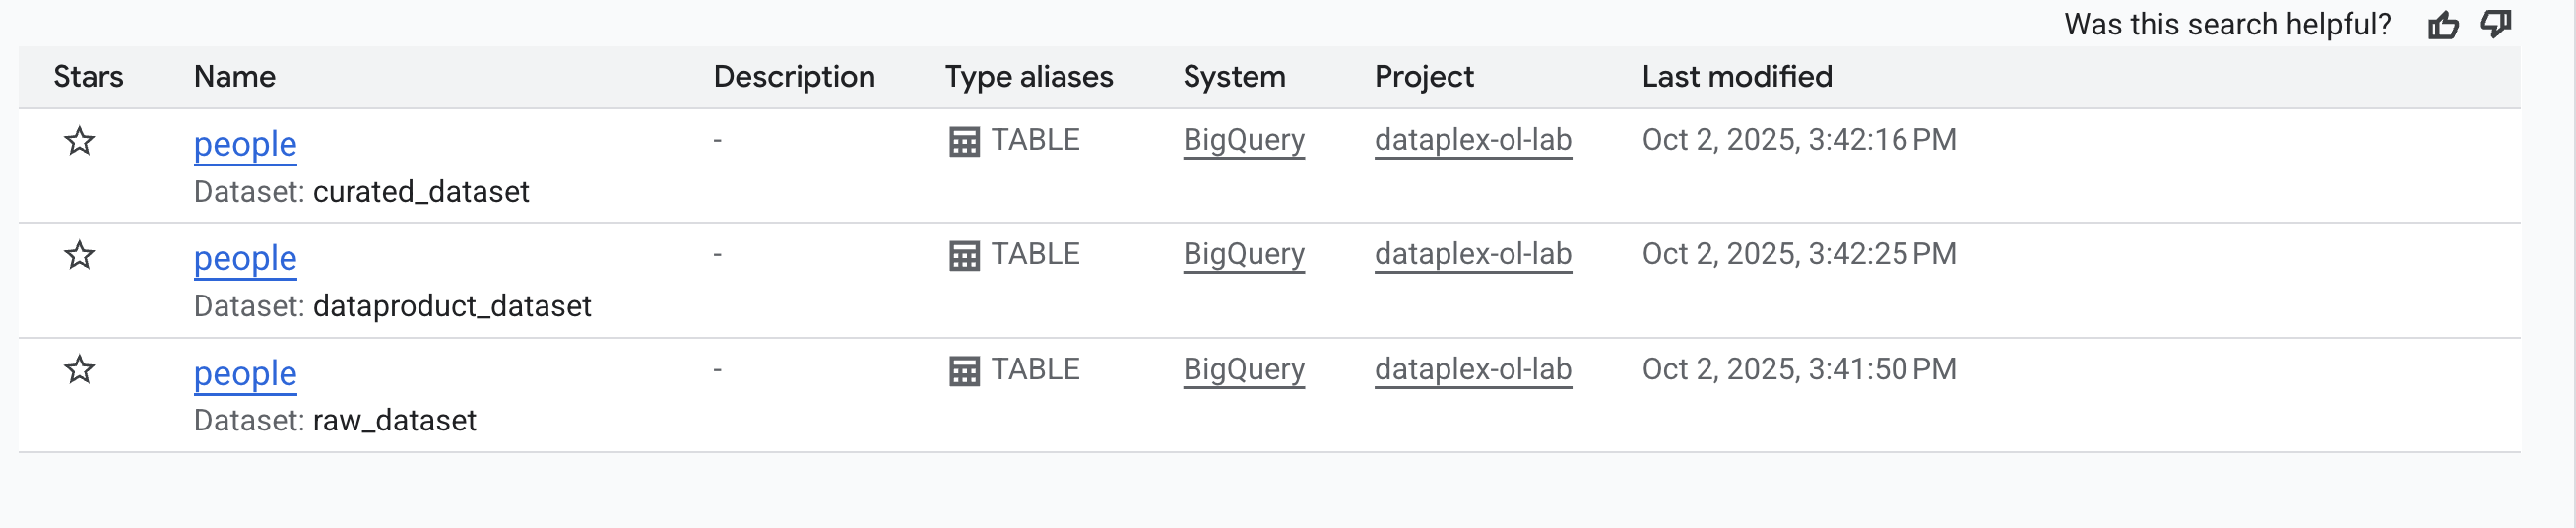

In [ ]:
#review aspects
print(f"Click on this url to view all entries in the 'RAW' zone Dataplex Universal Catalog.")

#https://console.cloud.google.com/dataplex/dp-search?project={GCP_PROJECT_ID}&qProjects={GCP_PROJECT_ID}&qAspectTypes=%257B%2522name%2522%253A%2522{GCP_PROJECT_ID}.{GCP_LOCATION}.zone%2522%252C%2522displayName%2522%253A%2522Zone%2520Type%2522%252C%2522subfilters%2522%253A%255B%257B%2522type%2522%253A%2522enum%2522%252C%2522name%2522%253A%2522zonename%2522%252C%2522displayName%2522%253A%2522Zone%2520Name%2522%252C%2522negated%2522%253Afalse%252C%2522range%2522%253Afalse%252C%2522value%2522%253A%255B%2522RAW%2522%255D%257D%255D%257D
print(f"link: https://console.cloud.google.com/dataplex/dp-search?project={GCP_PROJECT_ID}&qProjects={GCP_PROJECT_ID}&qAspectTypes=%257B%2522name%2522%253A%2522{GCP_PROJECT_ID}.{GCP_LOCATION}.zone%2522%252C%2522displayName%2522%253A%2522Zone%2520Type%2522%252C%2522subfilters%2522%253A%255B%257B%2522type%2522%253A%2522enum%2522%252C%2522name%2522%253A%2522zonename%2522%252C%2522displayName%2522%253A%2522Zone%2520Name%2522%252C%2522negated%2522%253Afalse%252C%2522range%2522%253Afalse%252C%2522value%2522%253A%255B%2522RAW%2522%255D%257D%255D%257D")

You will see one entry for the people table in the raw_dataset. <BR>
- If you click on that entry and scroll to the bottom you will see the two custom aspects: (as shown below)<BR>
-- domain<BR>
-- zone<BR>
<hr>

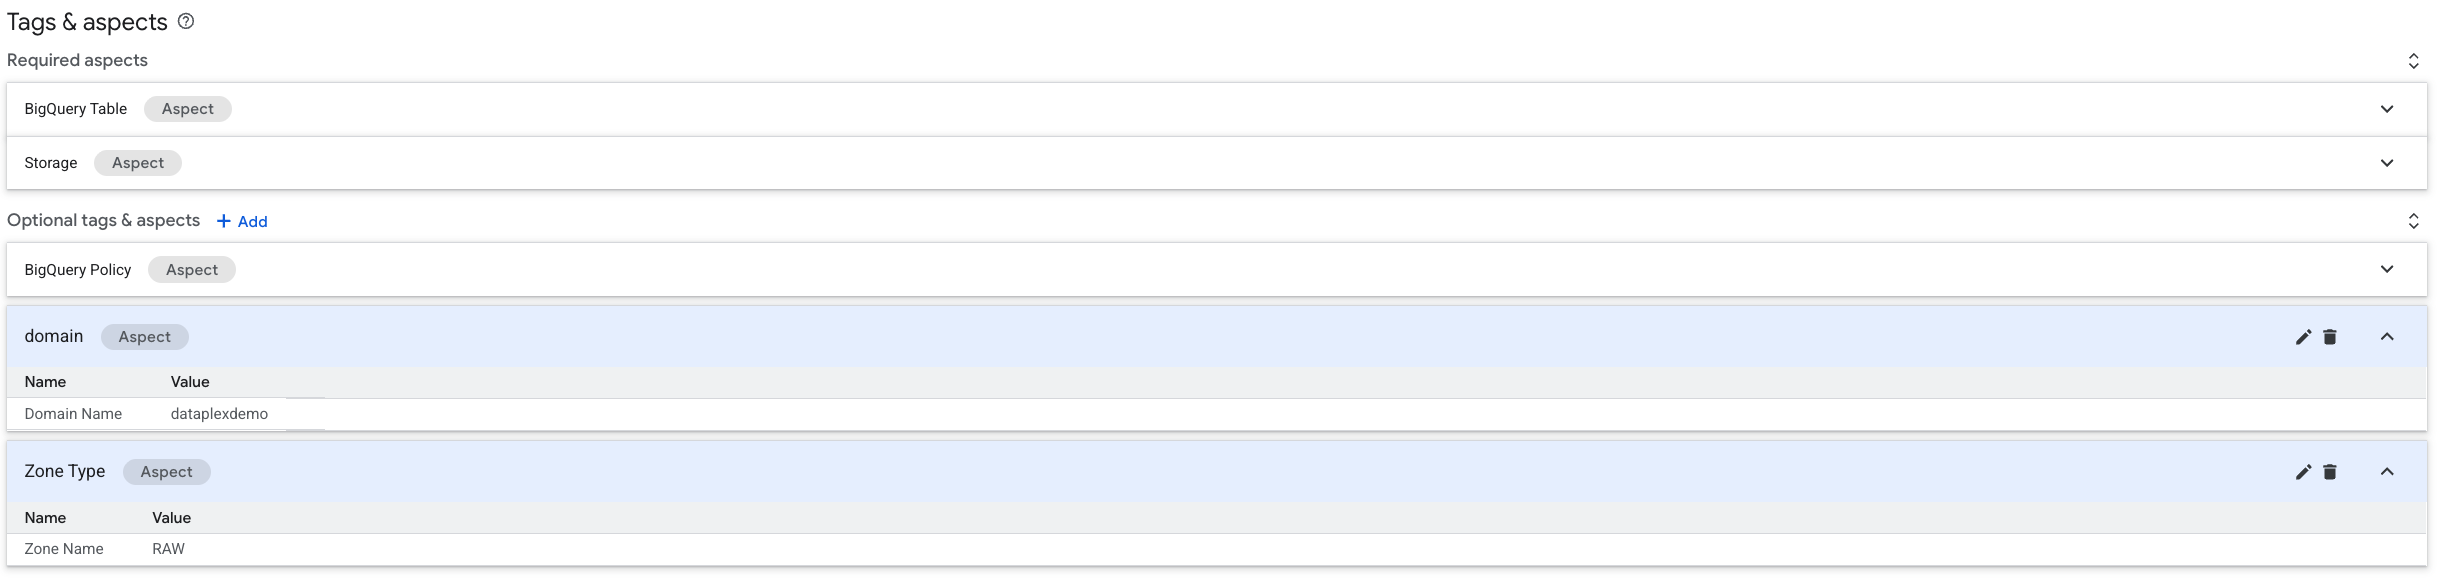

In [ ]:
# review column level lineage
print(f"Click on this url to view Column Level Lineage in the Dataplex Universal Catalog.")
print(f"After clicking on the link, click on column level lineage in Lineage Explorer and select column full_name and then click 'Apply'.")

print(f"link: https://console.cloud.google.com/dataplex/dp-entries/projects/{GCP_PROJECT_ID}/locations/{GCP_LOCATION}/entryGroups/@bigquery/entries/bigquery.googleapis.com%2Fprojects%2F{GCP_PROJECT_ID}%2Fdatasets%2Fcurated_dataset%2Ftables%2Fpeople?project={GCP_PROJECT_ID}#lineage")
#https://console.cloud.google.com/dataplex/dp-entries/projects/{GCP_PROJECT_ID}/locations/us/entryGroups/@bigquery/entries/bigquery.googleapis.com%2Fprojects%2F{GCP_PROJECT_ID}%2Fdatasets%2Fcurated_dataset%2Ftables%2Fpeople?project={GCP_PROJECT_ID}#lineage

You should see two results similar to entries similar to the list below:<BR>
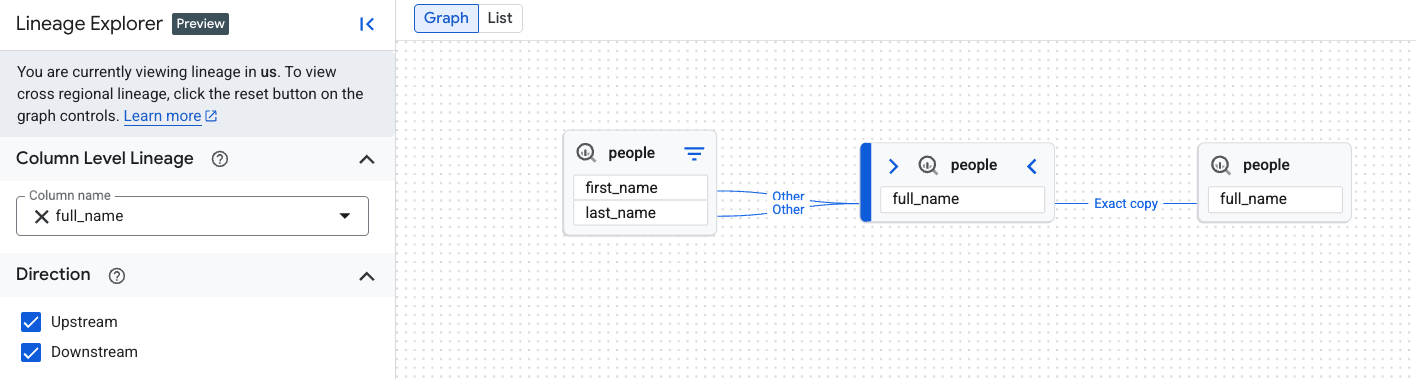

#Create and Apply Policy Tag

In [ ]:
taxonomy_name = createTaxonomy(GCP_PROJECT_ID, GCP_LOCATION, TAXONOMY_ID, TAXONOMY_ID)

policy_email = createPolicyTag(GCP_PROJECT_ID, taxonomy_name, None, "policy_email")
print(f"policy_email: {policy_email}")

In [ ]:
#update the people schema in the DATAPRODUCT dataset to include the policy tag
people_schema = createPeopleSchema()
updateTableSchema(GCP_PROJECT_ID, DATAPRODUCT_DATASET_NAME, TABLE_NAME, people_schema)

In [ ]:
#create a datamask policy for email
datamask_policy_email_email_mask = createDataPolicy(GCP_PROJECT_ID, GCP_LOCATION, policy_email,
                                                    "datamask_policy_email_email_mask", "DATA_MASKING_POLICY", "EMAIL_MASK")

In [ ]:
# give the user running the notebook finegrained reader permission on the email column
user = !(gcloud auth list --filter=status:ACTIVE --format="value(account)")
user = user[0]
print(user)
securePolicyTag(GCP_PROJECT_ID, GCP_LOCATION, user, policy_email)

In [ ]:
# create a service account that will only be able to see the masked email
params = {
    "project_id": f"{GCP_PROJECT_ID}"
}
createServiceAccount(params, UMSA, "Masked Rader Service Account", UMSA_FQN)
project_number_list = !gcloud projects describe {project_id} --format="value(projectNumber)"
project_number = project_number_list[0]
command=f"""gcloud iam service-accounts add-iam-policy-binding {UMSA_FQN} --member="user:{user}" --role='roles/iam.serviceAccountTokenCreator'"""
!{command}

In [ ]:
#give the service account access to the dataproduct dataset
cmd = f"""
gcloud projects add-iam-policy-binding {GCP_PROJECT_ID} \
--member="serviceAccount:maskedreader-sa@{GCP_PROJECT_ID}.iam.gserviceaccount.com" \
--role="roles/bigquery.dataViewer" \
--condition='expression=resource.name.startsWith("projects/{GCP_PROJECT_ID}/datasets/{DATAPRODUCT_DATASET_NAME}/tables/{TABLE_NAME}"),title=AccessToSpecificDataset'
"""
!{cmd}
print(cmd)

In [ ]:
#give the service account the job user role
cmd = f"""
gcloud projects add-iam-policy-binding {GCP_PROJECT_ID} \
--member="serviceAccount:maskedreader-sa@{GCP_PROJECT_ID}.iam.gserviceaccount.com" \
--role="roles/bigquery.jobUser" \
--condition='None'
"""
!{cmd}
print(cmd)

In [ ]:
# give the service account the masked reader role
secureDataPolicy(GCP_PROJECT_ID, GCP_LOCATION, UMSA_FQN, datamask_policy_email_email_mask)

In [ ]:
#query as logged-in user and you should see full email
import google.cloud.bigquery as bigquery
client = bigquery.Client()
query = f"SELECT full_name, email FROM `{DATAPRODUCT_DATASET_NAME}.{TABLE_NAME}` LIMIT 5"
query_job = client.query(query)
print("--- Query Results ---")
for row in query_job.result():
    # Each 'row' is a bigquery.Row object, which acts like a tuple/list
    print(row)



In [ ]:
#query as service account and you should see masked email
import google.auth
from google.auth import impersonated_credentials

base_credentials, project_id = google.auth.default()

credentials = impersonated_credentials.Credentials(
    source_credentials=base_credentials,
    target_principal=UMSA_FQN,
    target_scopes=["https://www.googleapis.com/auth/cloud-platform"],
    lifetime=300 # Token lifetime in seconds (e.g., 5 minutes)
)

client = bigquery.Client(
    project=GCP_PROJECT_ID,
    credentials=credentials
)

query = f"SELECT full_name, email FROM `{DATAPRODUCT_DATASET_NAME}.{TABLE_NAME}` LIMIT 5"
query_job = client.query(query)
print("--- Query Results ---")
for row in query_job.result():
    # Each 'row' is a bigquery.Row object, which acts like a tuple/list
    print(row)
